Mounted at /content/drive
Epoch 1/20, Loss: 0.024330758266150953
Epoch 2/20, Loss: 0.0048104066215455535
Epoch 3/20, Loss: 0.005217525828629732
Epoch 4/20, Loss: 0.0037191459722816945
Epoch 5/20, Loss: 0.002660280107520521
Epoch 6/20, Loss: 0.0023424299689941107
Epoch 7/20, Loss: 0.0020582088478840886
Epoch 8/20, Loss: 0.0017432833509519697
Epoch 9/20, Loss: 0.0019101672107353807
Epoch 10/20, Loss: 0.0019259845977649093
Epoch 11/20, Loss: 0.0019449767563492059
Epoch 12/20, Loss: 0.0017713878583163023
Epoch 13/20, Loss: 0.0016975425160489976
Epoch 14/20, Loss: 0.0016203393321484328
Epoch 15/20, Loss: 0.0015993179194629193
Epoch 16/20, Loss: 0.0014386264560744167
Epoch 17/20, Loss: 0.0014483481156639755
Epoch 18/20, Loss: 0.0017823186377063393
Epoch 19/20, Loss: 0.0015350312273949385
Epoch 20/20, Loss: 0.001409064355539158
GPU memory cleared


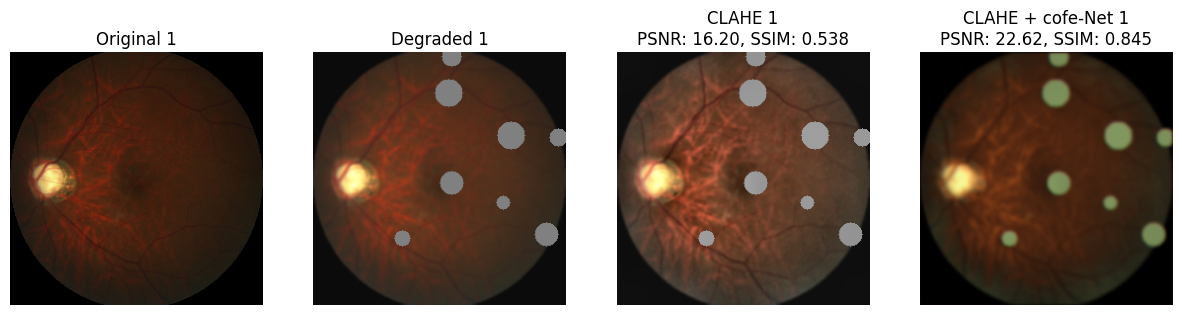

Image 1 - CLAHE: PSNR = 16.20, SSIM = 0.538
Image 1 - CLAHE + cofe-Net: PSNR = 22.62, SSIM = 0.845


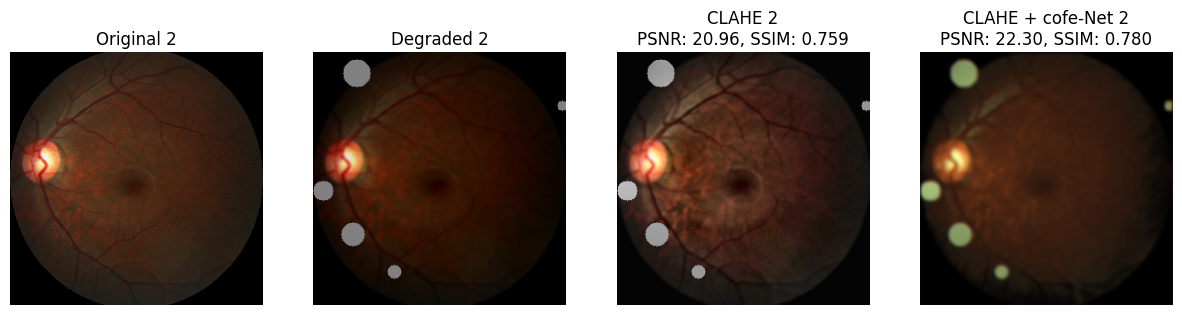

Image 2 - CLAHE: PSNR = 20.96, SSIM = 0.759
Image 2 - CLAHE + cofe-Net: PSNR = 22.30, SSIM = 0.780


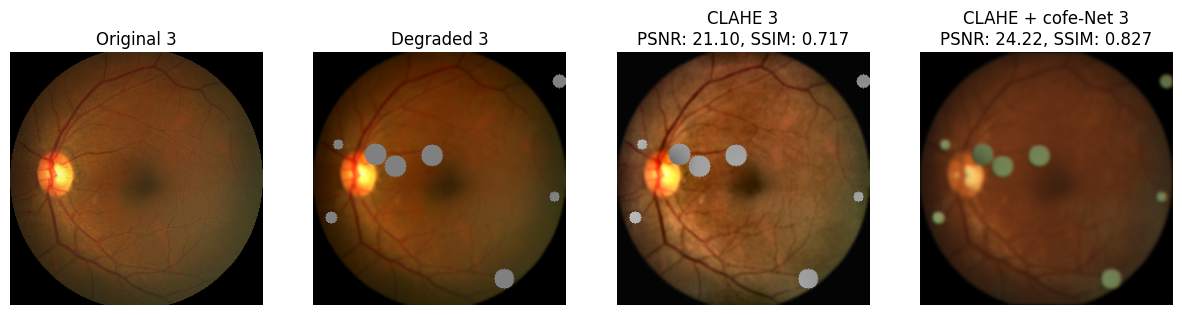

Image 3 - CLAHE: PSNR = 21.10, SSIM = 0.717
Image 3 - CLAHE + cofe-Net: PSNR = 24.22, SSIM = 0.827


In [1]:
# Import libraries
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from google.colab import drive
from torch.utils.data import Dataset, DataLoader
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
dataset_path = "/content/drive/MyDrive/Refuge/REFUGE2/train/images"
high_quality_dir = "/content/drive/MyDrive/Refuge/REFUGE2/train/high_quality"
low_quality_dir = "/content/drive/MyDrive/Refuge/REFUGE2/train/low_quality"

# Load images
def load_multiple_images(folder, num_images=3, start_index=0):
    images = []
    count = 0
    for i, filename in enumerate(os.listdir(folder)):
        if i < start_index: continue
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            count += 1
            if count >= num_images: break
    if not images: raise FileNotFoundError("No valid images found!")
    return images

# Degradation functions (simplified)
def apply_light_transmission_disturbance(img):
    alpha = np.random.uniform(0.8, 1.2)
    beta = np.random.uniform(-20, 20)
    img_degraded = img.astype(float) * alpha + beta
    return np.clip(img_degraded, 0, 255).astype(np.uint8)

def apply_image_blurring(img):
    return cv2.GaussianBlur(img, (5, 5), 0)

def apply_retinal_artifacts(img):
    h, w = img.shape[:2]
    num_artifacts = np.random.randint(5, 10)
    img_degraded = img.copy()
    for _ in range(num_artifacts):
        x, y = np.random.randint(0, w), np.random.randint(0, h)
        radius = np.random.randint(5, 15)
        cv2.circle(img_degraded, (x, y), radius, (128, 128, 128), -1)
    return img_degraded

def degrade_image(img):
    img_degraded = apply_light_transmission_disturbance(img)
    img_degraded = apply_image_blurring(img_degraded)
    img_degraded = apply_retinal_artifacts(img_degraded)
    return img_degraded

# CLAHE function
def apply_clahe(img):
    img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_lab[:,:,0] = clahe.apply(img_lab[:,:,0])
    return cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)

# Generate paired dataset
def generate_paired_dataset(num_images=50):
    os.makedirs(high_quality_dir, exist_ok=True)
    os.makedirs(low_quality_dir, exist_ok=True)
    images = []
    for filename in os.listdir(dataset_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(dataset_path, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append((filename, img))
            if len(images) >= num_images: break
    for i, (filename, img) in enumerate(images):
        degraded_img = degrade_image(img)
        cv2.imwrite(os.path.join(high_quality_dir, f"image_{i}.png"), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        cv2.imwrite(os.path.join(low_quality_dir, f"image_{i}.png"), cv2.cvtColor(degraded_img, cv2.COLOR_RGB2BGR))

# Dataset class
class FundusDataset(Dataset):
    def __init__(self, high_quality_dir, low_quality_dir, transform=None):
        self.hq_dir = high_quality_dir
        self.lq_dir = low_quality_dir
        self.transform = transform
        self.images = [f for f in os.listdir(high_quality_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        hq_img = cv2.imread(os.path.join(self.hq_dir, self.images[idx]))
        lq_img = cv2.imread(os.path.join(self.lq_dir, self.images[idx]))
        hq_img = cv2.cvtColor(hq_img, cv2.COLOR_BGR2RGB)
        lq_img = cv2.cvtColor(lq_img, cv2.COLOR_BGR2RGB)
        lq_img = apply_clahe(lq_img)  # CLAHE pre-processing

        if self.transform:
            hq_img = self.transform(hq_img)
            lq_img = self.transform(lq_img)
        return lq_img, hq_img

# LQA, RSA, and cofe-Net (unchanged from your original)
class LQAModule(nn.Module):
    def __init__(self):
        super(LQAModule, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 3, 3, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return self.sigmoid(self.conv3(x))

class RSAModule(nn.Module):
    def __init__(self):
        super(RSAModule, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 3, 3, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return self.sigmoid(self.conv3(x))

class CofeNet(nn.Module):
    def __init__(self):
        super(CofeNet, self).__init__()
        self.lqa = LQAModule()
        self.rsa = RSAModule()
        self.enhancer = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, 3, padding=1),
        )

    def forward(self, x):
        lqa_map = self.lqa(x)
        rsa_map = self.rsa(x)
        x_adjusted = x + (rsa_map - lqa_map) * 0.1
        enhanced = self.enhancer(x_adjusted)
        enhanced = (enhanced - enhanced.min()) / (enhanced.max() - enhanced.min() + 1e-8)
        return enhanced

# Training (simplified, assuming perceptual loss is optional)
def train_model(model, train_loader, epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    mse_loss = nn.MSELoss()
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for lq_img, hq_img in train_loader:
            lq_img, hq_img = lq_img.to(device), hq_img.to(device)
            optimizer.zero_grad()
            output = model(lq_img)
            loss = mse_loss(output, hq_img)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}")
    torch.save(model.state_dict(), "/content/cofenet_trained.pth")

# Display function
def display_more_images(num_images=3, start_index=1):
    clear_gpu_memory()
    images = load_multiple_images(dataset_path, num_images, start_index)
    transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize((256, 256)), transforms.ToTensor()])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CofeNet()
    try:
        model.load_state_dict(torch.load("/content/cofenet_trained.pth"))
        model = model.to(device)
    except:
        print("Model loading failed. Switching to CPU or retrain.")
        device = torch.device("cpu")
        model = model.to(device)

    model.eval()

    for i, img in enumerate(images):
        img_resized = cv2.resize(img, (256, 256))
        degraded_img = degrade_image(img_resized)
        clahe_img = apply_clahe(degraded_img)
        clahe_tensor = transform(clahe_img).unsqueeze(0).to(device)
        with torch.no_grad():
            enhanced_tensor = model(clahe_tensor)
        enhanced_img = enhanced_tensor.squeeze(0).cpu().numpy()
        enhanced_img = np.transpose(enhanced_img, (1, 2, 0)) * 255
        enhanced_img = enhanced_img.astype(np.uint8)

        psnr_enhanced = psnr(img_resized, enhanced_img, data_range=255)
        ssim_enhanced = ssim(img_resized, enhanced_img, multichannel=True, channel_axis=2, data_range=255)
        psnr_clahe = psnr(img_resized, clahe_img, data_range=255)
        ssim_clahe = ssim(img_resized, clahe_img, multichannel=True, channel_axis=2, data_range=255)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 4, 1); plt.title(f"Original {i+1}"); plt.imshow(img_resized); plt.axis("off")
        plt.subplot(1, 4, 2); plt.title(f"Degraded {i+1}"); plt.imshow(degraded_img); plt.axis("off")
        plt.subplot(1, 4, 3); plt.title(f"CLAHE {i+1}\nPSNR: {psnr_clahe:.2f}, SSIM: {ssim_clahe:.3f}"); plt.imshow(clahe_img); plt.axis("off")
        plt.subplot(1, 4, 4); plt.title(f"CLAHE + cofe-Net {i+1}\nPSNR: {psnr_enhanced:.2f}, SSIM: {ssim_enhanced:.3f}"); plt.imshow(enhanced_img); plt.axis("off")
        plt.show()

        print(f"Image {i+1} - CLAHE: PSNR = {psnr_clahe:.2f}, SSIM = {ssim_clahe:.3f}")
        print(f"Image {i+1} - CLAHE + cofe-Net: PSNR = {psnr_enhanced:.2f}, SSIM = {ssim_enhanced:.3f}")

def clear_gpu_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("GPU memory cleared")

# Run it
generate_paired_dataset()
train_dataset = FundusDataset(high_quality_dir, low_quality_dir, transform=transforms.Compose([transforms.ToPILImage(), transforms.Resize((256, 256)), transforms.ToTensor()]))
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
model = CofeNet()
train_model(model, train_loader)
display_more_images()